In [2]:
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
from torchsummary import summary
import pickle

import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('./FER_data.csv')

In [4]:
pixels = data['pixels'].values
emotions = data['emotion'].values
usage = data['usage'].values

X = np.array([np.fromstring(pixel, sep=' ') for pixel in pixels], dtype=np.float32)
X = X.reshape(-1, 48, 48, 1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(emotions)

X_train = X[usage == 'Training']
y_train = y[usage == 'Training']

X_val = X[usage == 'PublicTest']
y_val = y[usage == 'PublicTest']

X_test = X[usage == 'PrivateTest']
y_test = y[usage == 'PrivateTest']

In [5]:
class FERDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FERDataset(X_train, y_train, transform=train_transform)
val_dataset = FERDataset(X_val, y_val, transform=test_transform)
test_dataset = FERDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss
    

In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x= self.bn3(x)
        x = self.pool3(x)
        x= self.dropout3(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

model = CNNModel()

criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 15 

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {running_loss/len(train_loader):.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/15], Training Loss: 1.0191, Training Accuracy: 44.89%, Validation Loss: 0.7834, Validation Accuracy: 56.73%
Epoch [2/15], Training Loss: 0.8088, Training Accuracy: 55.80%, Validation Loss: 0.6721, Validation Accuracy: 62.58%
Epoch [3/15], Training Loss: 0.6895, Training Accuracy: 60.81%, Validation Loss: 0.5713, Validation Accuracy: 66.84%
Epoch [4/15], Training Loss: 0.6060, Training Accuracy: 64.96%, Validation Loss: 0.4982, Validation Accuracy: 70.60%
Epoch [5/15], Training Loss: 0.5440, Training Accuracy: 67.43%, Validation Loss: 0.4664, Validation Accuracy: 71.13%
Epoch [6/15], Training Loss: 0.4998, Training Accuracy: 69.31%, Validation Loss: 0.4431, Validation Accuracy: 73.17%
Epoch [7/15], Training Loss: 0.4520, Training Accuracy: 71.23%, Validation Loss: 0.4307, Validation Accuracy: 73.73%
Epoch [8/15], Training Loss: 0.4188, Training Accuracy: 72.90%, Validation Loss: 0.4008, Validation Accuracy: 75.17%
Epoch [9/15], Training Loss: 0.3849, Training Accuracy: 74.74%, 

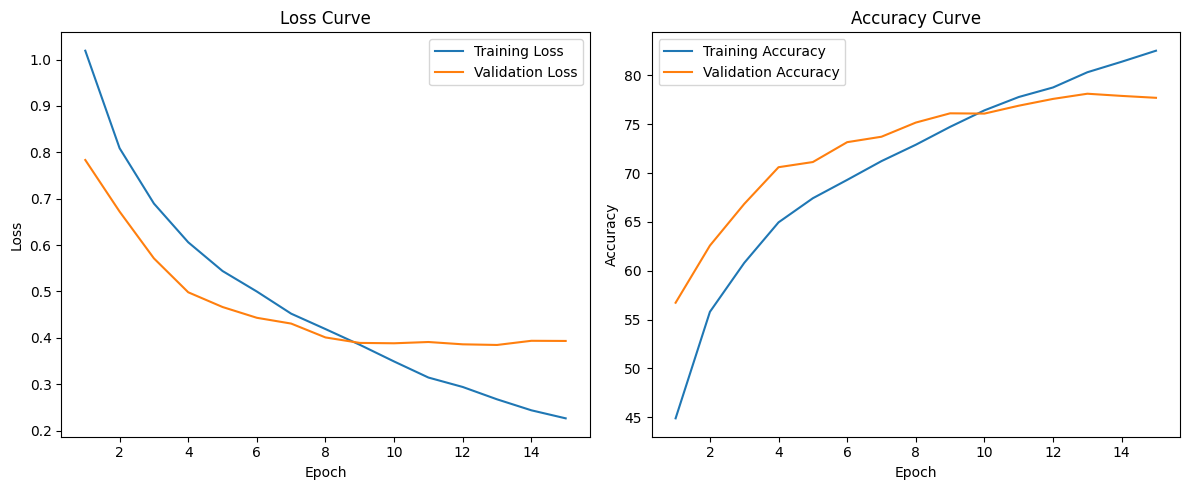

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
torch.save(model.state_dict(), './FER_model.pth')